In [ ]:
import numpy as np
from google.colab import drive
import csv
import sklearn.model_selection
# makes printing more human-friendly
np.set_printoptions(precision=3,suppress=True)

#Function to process the dataset. Input the google drive path to the dataset as well as the percentage of train and test
#Function outputs the standardized train, test, val datasets and labels as well as the std and mean used to standardize
#Output is: X_train, y_train, X_val, y_val, X_test, y_test, mean, std
def process_dataset(path='SolPred/curated-solubility-dataset.csv', train_percentage=0.7, test_percentage=0.15, val_percentage=0.15):


  #Loads the database and takes out specific indices as labels and features. If changing dataset change those indexes
  def loaddataset(path):
      drive.mount('/content/drive/')
      with open('/content/drive/MyDrive/'+path, 'r') as f:
        l = csv.reader(f)
        data = np.array([list(filter(None,i)) for i in l])
        X = data[1:,9:-1]
        y = data[1:,5]
        return X.astype(np.double),y.astype(np.double)

  #Splits the data into training data, validation data, and testing data, and normalizes the data with respect to the training portion
  #Returns the X_train, y_train, X_val, y_val, X_test, y_val, train_mean, train_std
  def traintestsplit_and_normalize(train_p, test_p, val_p, features, labels):
    #Split data
    X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(features,labels, train_size = train_p, shuffle=True )
    X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, train_size = val_p/(val_p+test_p))

    X_train = np.asfarray(X_train)
    X_val = np.asfarray(X_val)
    X_test = np.asfarray(X_test)

    X_mean = np.mean(X_train, axis=0)
    X_std = np.std(X_train, axis=0)

    X_train = (X_train-X_mean)/X_std
    X_val = (X_val-X_mean)/X_std
    X_test = (X_test-X_mean)/X_std
    return X_train, y_train, X_val, y_val, X_test, y_test, X_mean, X_std
  print('-----------------------------------------------------')

  print('loading dataset...')
  print('-----------------------------------------------------')

  X,y = loaddataset(path)

  #print(X[1])
  print('num_samples, num_features', X.shape)
  print('labels', y.shape)

  print('-----------------------------------------------------')
  print('Splitting dataset into train/test/val and normalizing')
  print('-----------------------------------------------------')

  X_train, y_train, X_val, y_val, X_test, y_test, X_mean, X_std = traintestsplit_and_normalize(train_percentage,val_percentage,test_percentage,X,y)
  print("Training features mean: " + str(np.mean(X_train)) + ", std: " + str(np.std(X_train)) + ", shape: " + str(X_train.shape))
  print("Validation features mean: " + str(np.mean(X_val)) + ", std: " + str(np.std(X_val)) + ", shape: " + str(X_val.shape))
  print("Testing features mean: " + str(np.mean(X_test)) + ", std: " + str(np.std(X_test)) + ", shape: " + str(X_test.shape))

  return X_train, y_train, X_val, y_val, X_test, y_test, X_mean, X_std

#Processes dataset with default values
X_train, y_train, X_val, y_val, X_test, y_test, mean, std = process_dataset()

-----------------------------------------------------
loading dataset...
-----------------------------------------------------
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
num_samples, num_features (9982, 19)
labels (9982,)
-----------------------------------------------------
Splitting dataset into train/test/val and normalizing
-----------------------------------------------------
Training features mean: -4.918824992004188e-16, std: 1.0000000000000036, shape: (6987, 19)
Validation features mean: 0.0007712258611146494, std: 0.9052830530325855, shape: (1497, 19)
Testing features mean: 0.048296642806657054, std: 1.222505604879925, shape: (1498, 19)


In [ ]:
import random
import torch

def data_iter(batch_size, features, labels):
  num_samples = len(features)
  indices = list(range(num_samples))
  random.shuffle(indices)

  for i in range(0, num_samples, batch_size):
    X, y = [],[]
    for j in indices[i:i+batch_size]:
      X.append(torch.from_numpy(features[j]))
      y.append(torch.from_numpy(np.array(labels[j])))
    yield torch.stack(X), torch.stack(y)

for X_batch, y_batch in data_iter(10, X_train,y_train):
  print('X_batch', X_batch.shape, X_batch.dtype)
  print('y_batch', y_batch.shape, y_batch.dtype)
  break

X_batch torch.Size([10, 19]) torch.float64
y_batch torch.Size([10]) torch.float64


In [ ]:
from torch import nn
class LinearANN(nn.Module):
  def __init__(self, input_dim):
        super(LinearANN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.softmax = nn.Softmax(dim=1)
        self.layer2 = nn.Linear(64,32)
        self.layer3 = nn.Linear(32,16)
        self.layer4 = nn.Linear(16,1)
        self.relu = nn.ReLU()
        self.double()

  def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return x

#Check model:
model = LinearANN(len(X_train[0]))

for X_batch, y_batch in data_iter(16, X_train, y_train):
    out_batch = model(X_batch)
    print('X_batch', X_batch.shape)
    print('out_batch', out_batch.shape)
    break

X_batch torch.Size([16, 19])
out_batch torch.Size([16, 1])


In [ ]:
LEARNING_RATE = 0.0001
#Training:
import torch.optim as optim

lossf = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
from scipy.optimize._lsq.trf_linear import make_strictly_feasible
#Training parameters
n_epochs = 200
batch_size = 10
batch_start = torch.arange(0,len(X_train),batch_size)

#For keeping track of best
best_mse = np.inf
best_weights = None
history = []

import tqdm
import copy
#Inspiration from https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
for epoch in range(n_epochs):
  model.train()
  with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
    bar.set_description(f"Epoch {epoch}")
    for X_batch, y_batch in data_iter(batch_size, X_train, y_train):
      y_pred = model(X_batch)
      loss = lossf(y_pred, y_batch.unsqueeze(1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      bar.set_postfix(mse=float(loss))
  model.eval()
  y_pred = model(torch.from_numpy(X_val))
  mse = lossf(y_pred,torch.from_numpy(y_val).unsqueeze(1))
  history.append(float(mse))
  if (mse < best_mse):
    print(mse.item())
    best_mse = mse
    best_weights = copy.deepcopy(model.state_dict())

model.load_state_dict(best_weights)

1.4758064215891142
0.9070106285668074
0.8389759167223987
0.8067724903561406
0.7897357997191861
0.7792588345411312
0.766886827908315
0.7531962903241849
0.7451641133168355
0.7370859622762677
0.73312881780403
0.723092906629534
0.7196563822763461
0.7114487097012365
0.7027518360576369
0.6977668094805237
0.6905625180786632
0.6900749718514735
0.6831379171960308
0.6746793564127451
0.6720336204785303
0.6668681601632814
0.6631863452348984
0.6523816377416687
0.6509478418276154
0.6498529143096872
0.6405362290660693
0.635341285021251
0.6318508384672868
0.6292692536972323
0.6274745323290201
0.6237360508121634
0.6151366504122077
0.6141968492812101
0.6128227377010516
0.6081395653351541
0.6064889837827865
0.6041385969179309
0.6023414491405945
0.5976429496156613
0.5973194754633622
0.5950813115213386
0.5927771855616255
0.5862747424299471
0.5819636818323769
0.5785656854034034
0.5766774174649666
0.5740155655719482
0.5720043050543594
0.568304350516526
0.5671271511310423
0.5623031027709999
0.5603843887411821

<All keys matched successfully>

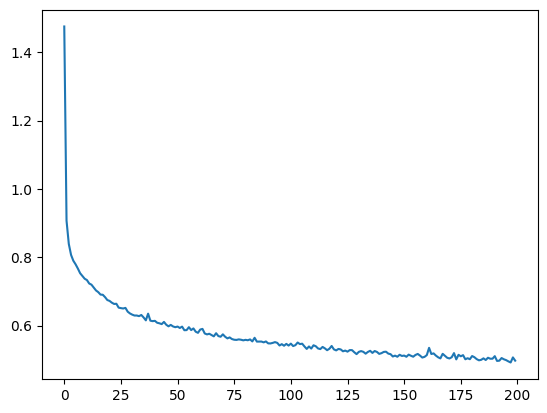

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history)

MSE: 0.5380914602859501, RMSE: 0.7335471765919014


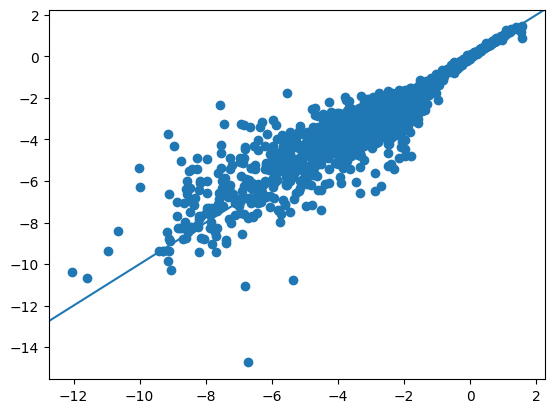

In [ ]:
from matplotlib import axes
#Test results:
y_pred = model(torch.from_numpy(X_test))
mse = lossf(y_pred,torch.from_numpy(y_test).unsqueeze(1))
print("MSE: " + str(mse.item()) + ", RMSE: " + str(torch.sqrt(mse).item()))
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred.detach().numpy())
ax.axline((0, 0), slope=1)


In [ ]:
import sklearn
from sklearn import metrics
print(y_pred)
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Insoluble", "Somewhat Solube", "Very Soluble"])

import matplotlib.pyplot as plt

cm_display.plot()
plt.show()

In [ ]:
maeloss = nn.L1Loss()
model2 = LinearANN(len(X_train[0]))
optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE)
#Training parameters
n_epochs = 100
batch_size = 10
batch_start = torch.arange(0,len(X_train),batch_size)

#For keeping track of best
best_mae = np.inf
best_weights = None
history = []

import tqdm
import copy
#Inspiration from https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
for epoch in range(n_epochs):
  model2.train()
  with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
    bar.set_description(f"Epoch {epoch}")
    for X_batch, y_batch in data_iter(batch_size, X_train, y_train):
      y_pred = model2(X_batch)
      loss = maeloss(y_pred, y_batch.unsqueeze(1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      bar.set_postfix(mae=float(loss))
  model2.eval()
  y_pred = model(torch.from_numpy(X_val))
  mae = lossf(y_pred,torch.from_numpy(y_val).unsqueeze(1))
  history.append(float(mae))
  if (mae < best_mae):
    print(mae.item())
    best_mae = mae
    best_weights = copy.deepcopy(model.state_dict())

model.load_state_dict(best_weights)

0.49176882298281194


<All keys matched successfully>

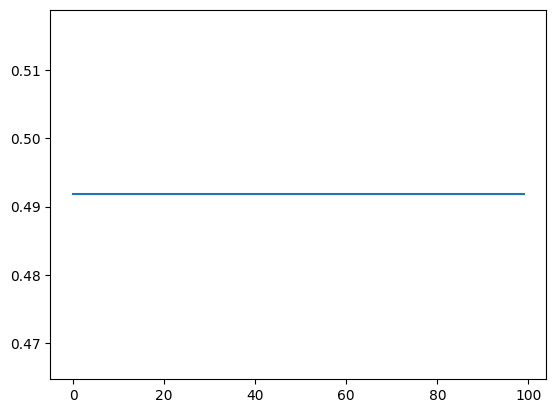

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history)